2018 Aug 9 <br>
Below I compare the light curve for Kepler-76 b based on parameters taken from Faigler's analysis (except for the mid-transit time, which I take from Experimenting_with_Kepler-76b.ipynb). <br>

In this notebook, I try to reproduce as exactly as I can the fit reported by Faigler et al.<br>

Actually, one thing I haven't checked is whether my data conditioning approach is distorting the transit. I'll check that first before I wander into the wilderness here.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.robust.scale import mad
from scipy.signal import medfilt

from astropy import units as u
from evilmc import evparams, evmodel, convert_Kz

In [2]:
# From Faigler+ (2013 - http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta)
a = 1./0.221 #± 0.003
b = 0.944 # ± 0.011
per = 1.54492875*u.day
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s)

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*a
Ms = 1.2*u.solMass # ± 0.2
q = Mp.to('kg')/Ms.to('kg')

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
Omegas = vsini.to('m/s')/Rs.to('m')*per.to('s')

Ts = 6300. # ± 200
# From a few cells below
T0 = 0.68508434

coeffs = [0.313, 0.304]
saved_ep = evparams(per=per.to('day').value, a=a, T0=T0, p=Rp_over_Rs, 
              limb_dark="quadratic", b=b, F0=50.4e-6, Aplanet=50.4e-6, phase_shift=10.3/360., beta=0.07, q=q, Kz=Kz, 
                    Ts=Ts, Ws=[0.,0.,Omegas], u=coeffs)

2018 Aug 10<br>
It seems that I am probably distorting the shape of the transit by not masking it out when I filter the data. The following cells involve development of a new version of the filtering code to all for masking.

In [43]:
# From transit_utils

def median_boxcar_filter(time, data, window_length=None, endpoints='reflect',
        mask_ind=None):
    """
    Creates median boxcar filter and deals with endpoints

    Parameters
    ----------
    time : numpy array
        times associated with data array
    data : numpy array 
       Data array
    window_length: int
        A scalar giving the size of the median filter window
    endpoints : str
        How to deal with endpoints. 
        Only option right now is 'reflect', which extends the data array
        on both ends by reflecting the data
    mask_ind : optional, indices
        If None, ignored
        If an array of indices, it represents all the points to be masked 
        during the boxcar filtering.

    Returns
    -------
    filter : numpy array
        The filter array
    """

    filter_array = np.copy(data)
    # Create filter array
    if(endpoints == 'reflect'):
        last_index = len(data) - 1

        # If mask_ind provided, interpolate across the masked points
        if(mask_ind is not None):
            not_mask_ind = ~mask_ind
            filter_array[mask_ind] = np.interp(time[mask_ind],
                    time[not_mask_ind], filter_array[not_mask_ind])
            
        filter_array =\
                np.concatenate((np.flip(filter_array[0:window_length], 0),
                    filter_array,
                    filter_array[last_index - window_length:last_index]))

        # Make filter
        # Check that window_length is odd
        if(window_length % 2 == 0):
            window_length += 1
        filt = medfilt(filter_array, window_length)

        filt = filt[window_length:window_length + last_index + 1]

    return filt


In [44]:
# %load variable_eclipses_utils.py
# 2018 Aug 9 - This file contains routines tailored to our analysis of 
#   eclipse variability.

import numpy as np
from glob import glob
from lightkurve import KeplerLightCurveFile

from transit_utils import flag_outliers, transit_duration

def retreive_data(period, num_periods=2, KIC=4570949, drop_outliers=True, 
        downloaded=True, base_dir="mastDownload/Kepler/",
        params=None):
    """
    Retreives and conditions data for the given KIC object

    Args:
        period (float) - orbital period for the transiting planet
        num_periods (int, optional) - window size for median filter
        KIC (optional, int) - KIC number
        drop_outliers (optional, boolean) - drop outliers?
        downloaded (optional, boolean) - whether data are DLed
        base_dir (optional, str) - directory under which to find data files
        params (optional, evilmc.evparams) - if not None, the routine masks
            points in transit (as indicated by the params values)
            while conditioning the data

    Returns:
        time (float array) - observational times
        flux (float array) - unconditioned light curve data
        filtered_time (float array) - observational times, conditioned
        filtered_flux (float array) - observational data, conditioned

    """

    if(not downloaded):
        for q in range(0, 18):
            lc = KeplerLightCurveFile.from_archive(str(KIC), 
                    quarter=q, verbose=False).PDCSAP_FLUX

    time = np.array([])
    flux = np.array([])

    filtered_time = np.array([])
    filtered_flux = np.array([])

    # Collect all data files
    ls = glob(base_dir + "kplr*" + str(KIC) + "_lc_Q*/*.fits")
    for cur_file in ls[0:1]:
     # PDCSAP_FLUX supposedly takes care of the flux fraction - 
     # _Data Processing Handbook_, p. 129
     # https://archive.stsci.edu/kepler/manuals/KSCI-19081-002-KDPH.pdf
        lc = KeplerLightCurveFile(cur_file).PDCSAP_FLUX
        lc.remove_nans()

        cur_time = lc.time
        cur_flux = lc.flux

        time = np.append(time, cur_time)
        flux = np.append(flux, cur_flux)

        cur_flux = (cur_flux - np.nanmedian(cur_flux))/np.nanmedian(cur_flux)
        window = num_periods*period
        del_t = np.median(cur_time[1:] - cur_time[:-1])
        window_length = int(window/del_t)

        # Indicate all points in transit
        ind = None
        if(params is not None):
            folded_time = cur_time % period

            dur = transit_duration(params, which_duration='full')

            # This expression below should technically be
            # ind = np.abs(folded_time - params.T0) < 0.5*dur, but
            # I'm taking a little window to either side of the transit
            # to make sure I'm masking everything.
            ind = np.abs(folded_time - params.T0) < dur

        filt = median_boxcar_filter(cur_time, cur_flux, 
            window_length, mask_ind=ind)

        filtered_time = np.append(filtered_time, cur_time)
        filtered_flux = np.append(filtered_flux, cur_flux - filt)

    if(drop_outliers):
        ind = flag_outliers(filtered_flux)
        filtered_time = filtered_time[ind]
        filtered_flux = filtered_flux[ind]

    return time, flux, filtered_time, filtered_flux


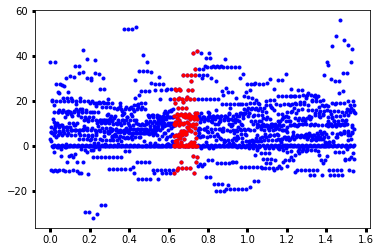

In [58]:
time, flux, filtered_time, masked_filtered_flux = retreive_data(per.to('day').value, params=saved_ep, drop_outliers=False)

time, flux, filtered_time, filtered_flux = retreive_data(per.to('day').value, drop_outliers=False)
folded_time = filtered_time % per.to('day').value

plt.plot(folded_time, (filtered_flux - masked_filtered_flux)*1e6, 'b.')

dur = transit_duration(saved_ep, which_duration='full')
ind = np.abs(folded_time - saved_ep.T0) < dur
plt.plot(folded_time[ind], (filtered_flux - masked_filtered_flux)[ind]*1e6, 'r.')

And there it is - not masking the transit distorts the signal by several tens of ppm, probably enough to explain the distortion I've seen.